6091


Processing grayscale images: 100%|██████████| 6091/6091 [00:12<00:00, 476.45it/s]


Average MAE for original images: 0.1494
Average MAE for grayscale images: 0.1796
Median MAE for original images: 0.1484
Median MAE for grayscale images: 0.1667


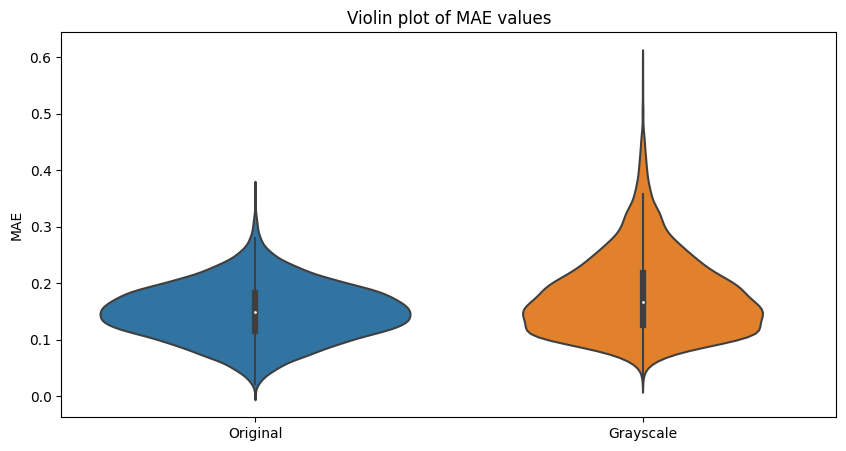

In [5]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import io, img_as_float
from skimage.metrics import structural_similarity as ssim
from pathlib import Path
import numpy as np
from skimage.transform import resize
from tqdm import tqdm
# 1. 加载数据
def load_subdirs(dataset_path):
    dataset_path = Path(dataset_path)
    subdirs = [subdir for subdir in dataset_path.iterdir() if subdir.is_dir()]
    subdir_names = [subdir.name for subdir in subdirs]
    return subdir_names, subdirs

# 2. 查找交集
dataset1_path = '/home/workstation/code/XAImethods/CAIN/results/imagenet/val_images10k_attack/defocus_blur/1_vit/google/vit-large-patch32-384/GradCAM'
dataset2_path = '/home/workstation/code/XAImethods/CAIN/results/imagenet/val_images10k_vit/google/vit-large-patch32-384/GradCAM'


subdir_names1, subdirs1 = load_subdirs(dataset1_path)
subdir_names2, subdirs2 = load_subdirs(dataset2_path)

common_subdir_names = set(subdir_names1).intersection(subdir_names2)
common_subdirs1 = [subdirs1[subdir_names1.index(subdir_name)] for subdir_name in common_subdir_names]
common_subdirs2 = [subdirs2[subdir_names2.index(subdir_name)] for subdir_name in common_subdir_names]
print(len(common_subdir_names))

def compute_mae_for_subdir(subdir1, subdir2):
    grayscale1_path = subdir1 / "grayscale.jpg"
    grayscale2_path = subdir2 / "grayscale.jpg"
    
    try:
        grayscale1 = img_as_float(io.imread(grayscale1_path, as_gray=True))
        grayscale2 = img_as_float(io.imread(grayscale2_path, as_gray=True))
        
        # Compute MAE
        mae_value = np.mean(np.abs(grayscale1 - grayscale2))
        return mae_value
    except Exception as e:
        print(f"Error processing {subdir1.name}. Error: {e}")
        return None

def compute_mae_for_original(subdir1, subdir2):
    original1_path = subdir1 / "original.jpg"
    original2_path = subdir2 / "original.jpg"
    
    try:
        original1 = img_as_float(io.imread(original1_path, as_gray=True))
        original2 = img_as_float(io.imread(original2_path, as_gray=True))
        
        # Ensure both images have the same dimensions
        if original1.shape != original2.shape:
            original1 = resize(original1, original2.shape, mode='reflect')
        
        # Compute MAE
        mae_value = np.mean(np.abs(original1 - original2))
        return mae_value
    except Exception as e:
        print(f"Error processing {subdir1.name}. Error: {e}")
        return None

# Compute MAE for original images
mae_orig_values = [compute_mae_for_original(subdir1, subdir2) for subdir1, subdir2 in tqdm(zip(common_subdirs1, common_subdirs2), total=len(common_subdirs1), desc="Processing original images")]

mae_orig_values = [val for val in mae_orig_values if val is not None]

# Compute MAE for grayscale images
mae_gray_values = [compute_mae_for_subdir(subdir1, subdir2) for subdir1, subdir2 in tqdm(zip(common_subdirs1, common_subdirs2), total=len(common_subdirs1), desc="Processing grayscale images")]

mae_gray_values = [val for val in mae_gray_values if val is not None]


mean_mae_orig = np.mean(mae_orig_values)
mean_mae_gray = np.mean(mae_gray_values)

median_mae_orig = np.median(mae_orig_values)
median_mae_gray = np.median(mae_gray_values)

print(f"Average MAE for original images: {mean_mae_orig:.4f}")
print(f"Average MAE for grayscale images: {mean_mae_gray:.4f}")
print(f"Median MAE for original images: {median_mae_orig:.4f}")
print(f"Median MAE for grayscale images: {median_mae_gray:.4f}")

# Generate the name for the new directory
new_dir_name = "_".join(dataset1_path.split('/')[-5:-3]) + "_" + "_".join(dataset2_path.split('/')[-4:-2])+ "_" + dataset1_path.split('/')[-1]
results_path = Path(new_dir_name)
results_path.mkdir(exist_ok=True)  # Create directory if it doesn't exist

# Plotting and saving
plt.figure(figsize=(10, 5))
sns.violinplot(data=[mae_orig_values, mae_gray_values])
plt.xticks([0, 1], ['Original', 'Grayscale'])
plt.title('Violin plot of MAE values')
plt.ylabel('MAE')
image_output_path = results_path / "MAE_comparison.png"
plt.savefig(image_output_path)
plt.show()

# Enhanced results saving
output_filename = results_path / "mae_values_stats.txt"
with open(output_filename, 'w') as outfile:
    outfile.write("STATISTICS:\n")
    outfile.write("====================\n")
    outfile.write(f"Average MAE for original images: {mean_mae_orig:.4f}\n")
    outfile.write(f"Average MAE for grayscale images: {mean_mae_gray:.4f}\n")
    outfile.write(f"Median MAE for original images: {median_mae_orig:.4f}\n")
    outfile.write(f"Median MAE for grayscale images: {median_mae_gray:.4f}\n\n")
    
    outfile.write("MAE VALUES:\n")
    outfile.write("====================\n")
    outfile.write("Original Images:\n")
    outfile.write("--------------------\n")
    for value in mae_orig_values:
        outfile.write(f"{value:.4f}\n")
        
    outfile.write("\nGrayscale Images:\n")
    outfile.write("--------------------\n")
    for value in mae_gray_values:
        outfile.write(f"{value:.4f}\n")
